## Prepare datasets

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
DATA_PATH = "/content/drive/MyDrive/Dataset"

## Import some Library

In [3]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import matplotlib.pyplot as plt

## Datasets Loader

In [4]:
class CityScapes(torch.utils.data.Dataset):
  def __init__(self, image_folder_path, mask_folder_path, transform=None):
    self.image_folder_path = image_folder_path
    self.mask_folder_path = mask_folder_path
    self.transform = transform
    self.images = os.listdir(image_folder_path)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_folder_path, self.images[index])
    mask_path = os.path.join(self.mask_folder_path, self.images[index])
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask

In [5]:
os.listdir(DATA_PATH)

['annotations_prepped_train',
 'images_prepped_train',
 'images_prepped_test',
 'annotations_prepped_test']

In [6]:
TRAIN_IMG_DIR = os.path.join(DATA_PATH, 'images_prepped_train')
TRAIN_MASK_DIR = os.path.join(DATA_PATH, 'annotations_prepped_train')

TEST_IMG_DIR = os.path.join(DATA_PATH, 'images_prepped_test')
TEST_MASK_DIR = os.path.join(DATA_PATH, 'annotations_prepped_test')

In [7]:
data_transforms = A.Compose([
    A.Resize(256,256),
    A.Normalize(),
    ToTensorV2()
])

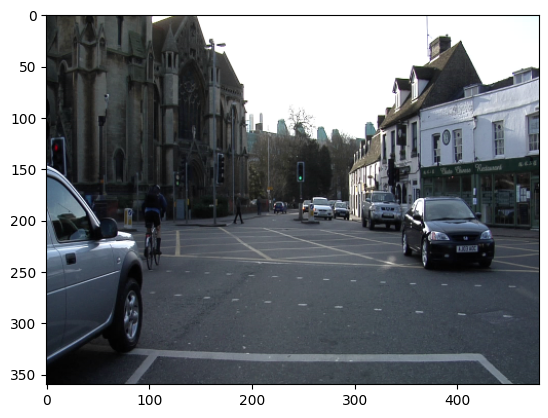

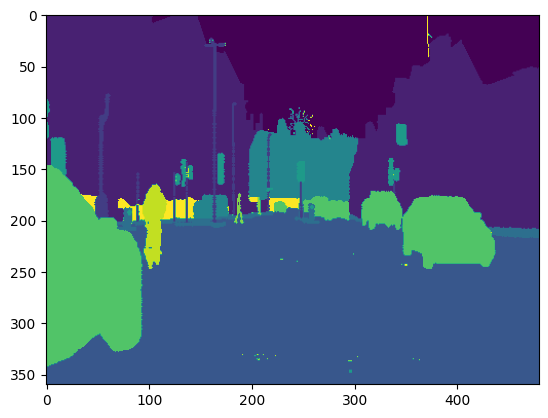

[ 0.  1.  2.  3.  4.  5.  6.  8.  9. 10. 11.]
(360, 480, 3)


In [8]:
sample = CityScapes(TRAIN_IMG_DIR, TRAIN_MASK_DIR)
image, mask = sample[0]
plt.imshow(image)
plt.show()
plt.imshow(mask)
plt.show()

print(np.unique(mask))
print(image.shape)

In [9]:
train_dataset = CityScapes(TRAIN_IMG_DIR, TRAIN_MASK_DIR, data_transforms)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

test_dataset = CityScapes(TEST_IMG_DIR, TEST_MASK_DIR, data_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

## Model Architecture

## DoubleConv

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

## UNet

In [11]:
class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # doblemconv, dobleconv..
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        #upsam, doubleconv, up, ..
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(#0
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))#1

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reversed(skip_connections)

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# FCN8s

In [12]:
class FCN8s(nn.Module):
  def __init__(self, in_channels, out_channels, features= [64, 128, 256, 512, 1024]):
    super().__init__()
    self.layers = nn.ModuleList()
    self.pool = nn.MaxPool2d(2, 2)

    for feature in features:
      self.layers.append(DoubleConv(in_channels, feature))
      in_channels = feature

    self.ups1 = nn.ConvTranspose2d(features[-1], features[-2], kernel_size=2, stride=2)
    self.ups2 = nn.ConvTranspose2d(features[-1], features[-3], kernel_size=2, stride=2)

    self.predictions = nn.ConvTranspose2d(features[-2], out_channels, kernel_size=8, stride=8)

  def forward(self, x):
    skip_connections=[]

    for idx,layer in enumerate(self.layers):
      x = layer(x)
      x = self.pool(x)
      if idx in [2,3]:
        skip_connections.append(x)


    ups1 = self.ups1(x)
    concat1 = torch.concat([ups1, skip_connections[-1]], dim=1)

    ups2 = self.ups2(concat1)
    concat2 = torch.concat([ups2, skip_connections[-2]], dim=1)

    return self.predictions(concat2)

## Engine function

## Dice coefficient metrics

In [13]:
def calculate_dice_coefficient(ground_truth, predicted):
    intersection = np.logical_and(ground_truth, predicted)
    dice_coefficient = (2 * np.sum(intersection)) / (np.sum(ground_truth) + np.sum(predicted))
    return dice_coefficient

def calculate_dice_coefficients(ground_truths, predictions):
    num_samples = len(ground_truths)
    dice_coefficients = np.zeros(num_samples)
    for i in range(num_samples):
      dice_coefficients[i] = calculate_dice_coefficient(ground_truths[i], predictions[i])
    return dice_coefficients

## IoU Metrics

In [14]:
def calculate_iou_score(ground_truth, predicted):
    intersection = np.logical_and(ground_truth, predicted)
    union = np.logical_or(ground_truth, predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_iou_scores(ground_truths, predictions):
    num_samples = len(ground_truths)
    iou_scores = np.zeros(num_samples)
    for i in range(num_samples):
        iou_scores[i] = calculate_iou_score(ground_truths[i], predictions[i])
    return iou_scores

## Training Phase

In [15]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 13.7 MB/s eta 0:00:00


In [16]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchmetrics

In [17]:
def check_dice_score(loader, model, device):
    dice_score = 0
    dice_score_function = torchmetrics.Dice(num_classes=12, average='micro').to(device)
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = torch.as_tensor(y, dtype=torch.int64, device=device)
            preds = model(x)
            dice_score += dice_score_function(preds, y)

    print(f"Dice score: {dice_score/len(loader)}")
    print(f"Loss Dice score: {1 - dice_score/len(loader)}")
    model.train()

In [18]:
def train_epoch(model, dataloader, criterion, optimizer, scaler, device):
  #please do training step in this function
  model.train()
  loss_one_step = 0
  loop = tqdm(dataloader)
  for data, targets in loop:
      data = data.to('cuda')
      targets = torch.as_tensor(targets, dtype=torch.int64, device=device)
      # forward
      with torch.cuda.amp.autocast():
          predictions = model(data)
          loss = criterion(predictions, targets)

      optimizer.zero_grad()
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      loss_one_step += loss.item()

      # update tqdm loop
      loop.set_postfix(loss=loss.item())

  return loss_one_step / len(dataloader)

def evaluate(model, dataloader, criterion, device):
  #please do evaluation step that calculate evaluation loss and evaluation metrics dice_score_coefficient
  model.eval()
  dice_score = 0
  dice_score_function = torchmetrics.Dice(num_classes=12, average='micro').to(device)

  loss_one_step = 0
  loop = tqdm(dataloader)

  for data, targets in loop:
      data = data.to('cuda')
      targets = torch.as_tensor(targets, dtype=torch.int64, device=device)
      with torch.no_grad():
          with torch.cuda.amp.autocast():
              predictions = model(data)
              loss = criterion(predictions, targets)

              # Dice Score
              dice_score += dice_score_function(predictions, targets)

      loss_one_step += loss.item()

      loop.set_postfix(loss=loss.item())

  return loss_one_step / len(dataloader), dice_score / len(dataloader)

In [19]:
def train(model, num_epochs=5):
  #please init everthing in here and do the training process
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
  scaler = torch.cuda.amp.GradScaler()
  for epoch in range(num_epochs):
    print(f"[INFO]: Epoch {epoch+1} of {num_epochs}")
    train_loss = train_epoch(model, train_dataloader, criterion, optimizer, scaler, device)
    test_loss, dice_score = evaluate(model, test_dataloader, criterion, device)
    print("\nDice Score : ", dice_score.cpu().numpy())
    print("Loss Dice Score : ", 1 - dice_score.cpu().numpy())
    print()

In [20]:
model = UNET(3, 12)
train(model, num_epochs=200)

[INFO]: Epoch 1 of 200


100%|██████████| 7/7 [01:24<00:00, 12.05s/it, loss=2.18]



Dice Score :  0.3778793
Loss Dice Score :  0.6221207082271576

[INFO]: Epoch 2 of 200


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, loss=1.33]



Dice Score :  0.7235989
Loss Dice Score :  0.2764011025428772

[INFO]: Epoch 3 of 200


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, loss=1.23]



Dice Score :  0.80195403
Loss Dice Score :  0.19804596900939941

[INFO]: Epoch 4 of 200


100%|██████████| 7/7 [00:01<00:00,  4.46it/s, loss=1.12]



Dice Score :  0.84185195
Loss Dice Score :  0.15814805030822754

[INFO]: Epoch 5 of 200


100%|██████████| 7/7 [00:02<00:00,  3.09it/s, loss=0.946]



Dice Score :  0.86084014
Loss Dice Score :  0.13915985822677612

[INFO]: Epoch 6 of 200


100%|██████████| 7/7 [00:02<00:00,  2.95it/s, loss=0.93]



Dice Score :  0.8420635
Loss Dice Score :  0.15793651342391968

[INFO]: Epoch 7 of 200


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, loss=0.759]



Dice Score :  0.8668855
Loss Dice Score :  0.1331145167350769

[INFO]: Epoch 8 of 200


100%|██████████| 7/7 [00:01<00:00,  4.49it/s, loss=0.737]



Dice Score :  0.8596161
Loss Dice Score :  0.14038389921188354

[INFO]: Epoch 9 of 200


100%|██████████| 7/7 [00:01<00:00,  4.67it/s, loss=0.686]



Dice Score :  0.86077
Loss Dice Score :  0.13923001289367676

[INFO]: Epoch 10 of 200


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, loss=0.646]



Dice Score :  0.8627945
Loss Dice Score :  0.13720548152923584

[INFO]: Epoch 11 of 200


100%|██████████| 7/7 [00:02<00:00,  2.99it/s, loss=0.639]



Dice Score :  0.86974096
Loss Dice Score :  0.13025903701782227

[INFO]: Epoch 12 of 200


100%|██████████| 7/7 [00:02<00:00,  2.96it/s, loss=0.793]



Dice Score :  0.8217995
Loss Dice Score :  0.17820048332214355

[INFO]: Epoch 13 of 200


100%|██████████| 7/7 [00:01<00:00,  4.26it/s, loss=0.549]



Dice Score :  0.873892
Loss Dice Score :  0.12610799074172974

[INFO]: Epoch 14 of 200


100%|██████████| 7/7 [00:01<00:00,  4.60it/s, loss=0.547]



Dice Score :  0.86029273
Loss Dice Score :  0.1397072672843933

[INFO]: Epoch 15 of 200


100%|██████████| 7/7 [00:01<00:00,  4.47it/s, loss=0.679]



Dice Score :  0.8425401
Loss Dice Score :  0.15745991468429565

[INFO]: Epoch 16 of 200


100%|██████████| 7/7 [00:01<00:00,  4.45it/s, loss=0.542]



Dice Score :  0.87215716
Loss Dice Score :  0.12784284353256226

[INFO]: Epoch 17 of 200


100%|██████████| 7/7 [00:02<00:00,  3.19it/s, loss=0.532]



Dice Score :  0.86972576
Loss Dice Score :  0.13027423620224

[INFO]: Epoch 18 of 200


100%|██████████| 7/7 [00:02<00:00,  2.91it/s, loss=0.513]



Dice Score :  0.8667846
Loss Dice Score :  0.13321542739868164

[INFO]: Epoch 19 of 200


100%|██████████| 7/7 [00:01<00:00,  4.22it/s, loss=0.515]



Dice Score :  0.867188
Loss Dice Score :  0.1328120231628418

[INFO]: Epoch 20 of 200


100%|██████████| 7/7 [00:01<00:00,  4.49it/s, loss=0.48]



Dice Score :  0.87281483
Loss Dice Score :  0.1271851658821106

[INFO]: Epoch 21 of 200


100%|██████████| 7/7 [00:01<00:00,  4.39it/s, loss=0.487]



Dice Score :  0.8690334
Loss Dice Score :  0.13096660375595093

[INFO]: Epoch 22 of 200


100%|██████████| 7/7 [00:01<00:00,  4.46it/s, loss=0.477]



Dice Score :  0.8698926
Loss Dice Score :  0.13010740280151367

[INFO]: Epoch 23 of 200


100%|██████████| 7/7 [00:02<00:00,  3.06it/s, loss=0.479]



Dice Score :  0.868707
Loss Dice Score :  0.13129299879074097

[INFO]: Epoch 24 of 200


100%|██████████| 7/7 [00:02<00:00,  2.87it/s, loss=0.63]



Dice Score :  0.83106124
Loss Dice Score :  0.1689387559890747

[INFO]: Epoch 25 of 200


100%|██████████| 7/7 [00:01<00:00,  4.01it/s, loss=0.45]



Dice Score :  0.8835737
Loss Dice Score :  0.11642628908157349

[INFO]: Epoch 26 of 200


100%|██████████| 7/7 [00:01<00:00,  4.41it/s, loss=0.481]



Dice Score :  0.86924005
Loss Dice Score :  0.13075995445251465

[INFO]: Epoch 27 of 200


100%|██████████| 7/7 [00:01<00:00,  4.61it/s, loss=0.427]



Dice Score :  0.88359594
Loss Dice Score :  0.11640405654907227

[INFO]: Epoch 28 of 200


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, loss=0.464]



Dice Score :  0.8673878
Loss Dice Score :  0.1326122283935547

[INFO]: Epoch 29 of 200


100%|██████████| 7/7 [00:02<00:00,  3.43it/s, loss=0.48]



Dice Score :  0.8682258
Loss Dice Score :  0.1317741870880127

[INFO]: Epoch 30 of 200


100%|██████████| 7/7 [00:02<00:00,  3.06it/s, loss=0.445]



Dice Score :  0.8807031
Loss Dice Score :  0.11929690837860107

[INFO]: Epoch 31 of 200


100%|██████████| 7/7 [00:01<00:00,  3.85it/s, loss=0.404]



Dice Score :  0.88595897
Loss Dice Score :  0.1140410304069519

[INFO]: Epoch 32 of 200


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, loss=0.395]



Dice Score :  0.8889342
Loss Dice Score :  0.1110658049583435

[INFO]: Epoch 33 of 200


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.426]



Dice Score :  0.8835786
Loss Dice Score :  0.1164214015007019

[INFO]: Epoch 34 of 200


100%|██████████| 7/7 [00:01<00:00,  4.46it/s, loss=0.408]



Dice Score :  0.8852893
Loss Dice Score :  0.11471068859100342

[INFO]: Epoch 35 of 200


100%|██████████| 7/7 [00:02<00:00,  3.37it/s, loss=0.443]



Dice Score :  0.87550133
Loss Dice Score :  0.12449866533279419

[INFO]: Epoch 36 of 200


100%|██████████| 7/7 [00:02<00:00,  2.90it/s, loss=0.375]



Dice Score :  0.88478374
Loss Dice Score :  0.11521625518798828

[INFO]: Epoch 37 of 200


100%|██████████| 7/7 [00:01<00:00,  4.47it/s, loss=0.417]



Dice Score :  0.8846786
Loss Dice Score :  0.11532139778137207

[INFO]: Epoch 38 of 200


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, loss=0.37]



Dice Score :  0.89205647
Loss Dice Score :  0.10794353485107422

[INFO]: Epoch 39 of 200


100%|██████████| 7/7 [00:01<00:00,  4.43it/s, loss=0.398]



Dice Score :  0.8889573
Loss Dice Score :  0.11104267835617065

[INFO]: Epoch 40 of 200


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, loss=0.361]



Dice Score :  0.8941802
Loss Dice Score :  0.10581982135772705

[INFO]: Epoch 41 of 200


100%|██████████| 7/7 [00:02<00:00,  3.13it/s, loss=0.38]



Dice Score :  0.8909652
Loss Dice Score :  0.10903477668762207

[INFO]: Epoch 42 of 200


100%|██████████| 7/7 [00:02<00:00,  2.94it/s, loss=0.366]



Dice Score :  0.88993365
Loss Dice Score :  0.11006635427474976

[INFO]: Epoch 43 of 200


100%|██████████| 7/7 [00:01<00:00,  3.80it/s, loss=0.375]



Dice Score :  0.8881472
Loss Dice Score :  0.11185282468795776

[INFO]: Epoch 44 of 200


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, loss=0.379]



Dice Score :  0.8896982
Loss Dice Score :  0.11030179262161255

[INFO]: Epoch 45 of 200


100%|██████████| 7/7 [00:01<00:00,  4.45it/s, loss=0.358]



Dice Score :  0.89229655
Loss Dice Score :  0.10770344734191895

[INFO]: Epoch 46 of 200


100%|██████████| 7/7 [00:01<00:00,  4.29it/s, loss=0.347]



Dice Score :  0.89719564
Loss Dice Score :  0.10280436277389526

[INFO]: Epoch 47 of 200


100%|██████████| 7/7 [00:01<00:00,  3.60it/s, loss=0.384]



Dice Score :  0.8932167
Loss Dice Score :  0.10678327083587646

[INFO]: Epoch 48 of 200


100%|██████████| 7/7 [00:02<00:00,  2.94it/s, loss=0.361]



Dice Score :  0.8915547
Loss Dice Score :  0.10844528675079346

[INFO]: Epoch 49 of 200


100%|██████████| 7/7 [00:02<00:00,  3.48it/s, loss=0.377]



Dice Score :  0.8944662
Loss Dice Score :  0.10553377866744995

[INFO]: Epoch 50 of 200


100%|██████████| 7/7 [00:01<00:00,  4.31it/s, loss=0.369]



Dice Score :  0.89731234
Loss Dice Score :  0.10268765687942505

[INFO]: Epoch 51 of 200


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, loss=0.345]



Dice Score :  0.9010788
Loss Dice Score :  0.09892117977142334

[INFO]: Epoch 52 of 200


100%|██████████| 7/7 [00:01<00:00,  4.44it/s, loss=0.342]



Dice Score :  0.8998849
Loss Dice Score :  0.10011512041091919

[INFO]: Epoch 53 of 200


100%|██████████| 7/7 [00:01<00:00,  4.05it/s, loss=0.364]



Dice Score :  0.8962825
Loss Dice Score :  0.10371750593185425

[INFO]: Epoch 54 of 200


100%|██████████| 7/7 [00:02<00:00,  2.97it/s, loss=0.343]



Dice Score :  0.8990981
Loss Dice Score :  0.10090190172195435

[INFO]: Epoch 55 of 200


100%|██████████| 7/7 [00:02<00:00,  3.26it/s, loss=0.334]



Dice Score :  0.9018016
Loss Dice Score :  0.09819841384887695

[INFO]: Epoch 56 of 200


100%|██████████| 7/7 [00:01<00:00,  4.36it/s, loss=0.355]



Dice Score :  0.89765656
Loss Dice Score :  0.10234344005584717

[INFO]: Epoch 57 of 200


100%|██████████| 7/7 [00:01<00:00,  4.60it/s, loss=0.363]



Dice Score :  0.8982569
Loss Dice Score :  0.10174310207366943

[INFO]: Epoch 58 of 200


100%|██████████| 7/7 [00:01<00:00,  4.46it/s, loss=0.345]



Dice Score :  0.9020928
Loss Dice Score :  0.0979071855545044

[INFO]: Epoch 59 of 200


100%|██████████| 7/7 [00:01<00:00,  3.84it/s, loss=0.397]



Dice Score :  0.8884909
Loss Dice Score :  0.11150908470153809

[INFO]: Epoch 60 of 200


100%|██████████| 7/7 [00:02<00:00,  2.90it/s, loss=0.356]



Dice Score :  0.8972788
Loss Dice Score :  0.1027212142944336

[INFO]: Epoch 61 of 200


100%|██████████| 7/7 [00:02<00:00,  3.20it/s, loss=0.35]



Dice Score :  0.9031851
Loss Dice Score :  0.09681487083435059

[INFO]: Epoch 62 of 200


100%|██████████| 7/7 [00:01<00:00,  4.65it/s, loss=0.351]



Dice Score :  0.90219724
Loss Dice Score :  0.09780275821685791

[INFO]: Epoch 63 of 200


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, loss=0.33]



Dice Score :  0.90358627
Loss Dice Score :  0.09641373157501221

[INFO]: Epoch 64 of 200


100%|██████████| 7/7 [00:01<00:00,  4.28it/s, loss=0.351]



Dice Score :  0.9013836
Loss Dice Score :  0.09861642122268677

[INFO]: Epoch 65 of 200


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.338]



Dice Score :  0.9025587
Loss Dice Score :  0.09744131565093994

[INFO]: Epoch 66 of 200


100%|██████████| 7/7 [00:02<00:00,  3.00it/s, loss=0.353]



Dice Score :  0.8980888
Loss Dice Score :  0.10191118717193604

[INFO]: Epoch 67 of 200


100%|██████████| 7/7 [00:02<00:00,  2.95it/s, loss=0.354]



Dice Score :  0.90259147
Loss Dice Score :  0.09740853309631348

[INFO]: Epoch 68 of 200


100%|██████████| 7/7 [00:01<00:00,  4.19it/s, loss=0.351]



Dice Score :  0.8992449
Loss Dice Score :  0.10075509548187256

[INFO]: Epoch 69 of 200


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, loss=0.358]



Dice Score :  0.9042871
Loss Dice Score :  0.09571290016174316

[INFO]: Epoch 70 of 200


100%|██████████| 7/7 [00:01<00:00,  4.45it/s, loss=0.354]



Dice Score :  0.8968606
Loss Dice Score :  0.10313940048217773

[INFO]: Epoch 71 of 200


100%|██████████| 7/7 [00:01<00:00,  4.49it/s, loss=0.341]



Dice Score :  0.90357715
Loss Dice Score :  0.09642285108566284

[INFO]: Epoch 72 of 200


100%|██████████| 7/7 [00:02<00:00,  3.32it/s, loss=0.33]



Dice Score :  0.90338296
Loss Dice Score :  0.09661704301834106

[INFO]: Epoch 73 of 200


100%|██████████| 7/7 [00:02<00:00,  2.93it/s, loss=0.341]



Dice Score :  0.9038658
Loss Dice Score :  0.09613418579101562

[INFO]: Epoch 74 of 200


100%|██████████| 7/7 [00:01<00:00,  3.97it/s, loss=0.362]



Dice Score :  0.90108776
Loss Dice Score :  0.09891223907470703

[INFO]: Epoch 75 of 200


100%|██████████| 7/7 [00:01<00:00,  4.43it/s, loss=0.349]



Dice Score :  0.9020646
Loss Dice Score :  0.09793537855148315

[INFO]: Epoch 76 of 200


100%|██████████| 7/7 [00:01<00:00,  4.69it/s, loss=0.359]



Dice Score :  0.89877063
Loss Dice Score :  0.10122936964035034

[INFO]: Epoch 77 of 200


100%|██████████| 7/7 [00:01<00:00,  4.52it/s, loss=0.339]



Dice Score :  0.900005
Loss Dice Score :  0.09999501705169678

[INFO]: Epoch 78 of 200


100%|██████████| 7/7 [00:02<00:00,  3.47it/s, loss=0.363]



Dice Score :  0.901896
Loss Dice Score :  0.09810400009155273

[INFO]: Epoch 79 of 200


100%|██████████| 7/7 [00:02<00:00,  2.97it/s, loss=0.342]



Dice Score :  0.90219563
Loss Dice Score :  0.09780436754226685

[INFO]: Epoch 80 of 200


100%|██████████| 7/7 [00:01<00:00,  4.08it/s, loss=0.351]



Dice Score :  0.89990205
Loss Dice Score :  0.10009795427322388

[INFO]: Epoch 81 of 200


100%|██████████| 7/7 [00:01<00:00,  4.51it/s, loss=0.333]



Dice Score :  0.90522105
Loss Dice Score :  0.09477895498275757

[INFO]: Epoch 82 of 200


100%|██████████| 7/7 [00:01<00:00,  4.46it/s, loss=0.344]



Dice Score :  0.9024832
Loss Dice Score :  0.09751677513122559

[INFO]: Epoch 83 of 200


100%|██████████| 7/7 [00:01<00:00,  4.42it/s, loss=0.346]



Dice Score :  0.9025849
Loss Dice Score :  0.09741508960723877

[INFO]: Epoch 84 of 200


100%|██████████| 7/7 [00:02<00:00,  3.39it/s, loss=0.341]



Dice Score :  0.9056032
Loss Dice Score :  0.09439682960510254

[INFO]: Epoch 85 of 200


100%|██████████| 7/7 [00:02<00:00,  3.10it/s, loss=0.342]



Dice Score :  0.90762013
Loss Dice Score :  0.0923798680305481

[INFO]: Epoch 86 of 200


100%|██████████| 7/7 [00:01<00:00,  4.22it/s, loss=0.356]



Dice Score :  0.90186805
Loss Dice Score :  0.09813195466995239

[INFO]: Epoch 87 of 200


100%|██████████| 7/7 [00:01<00:00,  4.51it/s, loss=0.361]



Dice Score :  0.90111655
Loss Dice Score :  0.09888345003128052

[INFO]: Epoch 88 of 200


100%|██████████| 7/7 [00:01<00:00,  4.44it/s, loss=0.365]



Dice Score :  0.8992384
Loss Dice Score :  0.10076159238815308

[INFO]: Epoch 89 of 200


100%|██████████| 7/7 [00:01<00:00,  4.56it/s, loss=0.379]



Dice Score :  0.8959176
Loss Dice Score :  0.10408240556716919

[INFO]: Epoch 90 of 200


100%|██████████| 7/7 [00:02<00:00,  3.44it/s, loss=0.367]



Dice Score :  0.90188915
Loss Dice Score :  0.0981108546257019

[INFO]: Epoch 91 of 200


100%|██████████| 7/7 [00:02<00:00,  3.12it/s, loss=0.364]



Dice Score :  0.90246665
Loss Dice Score :  0.09753334522247314

[INFO]: Epoch 92 of 200


100%|██████████| 7/7 [00:01<00:00,  4.03it/s, loss=0.332]



Dice Score :  0.90709704
Loss Dice Score :  0.09290295839309692

[INFO]: Epoch 93 of 200


100%|██████████| 7/7 [00:01<00:00,  4.54it/s, loss=0.367]



Dice Score :  0.90073544
Loss Dice Score :  0.09926456212997437

[INFO]: Epoch 94 of 200


100%|██████████| 7/7 [00:01<00:00,  4.43it/s, loss=0.366]



Dice Score :  0.9016255
Loss Dice Score :  0.09837448596954346

[INFO]: Epoch 95 of 200


100%|██████████| 7/7 [00:01<00:00,  4.45it/s, loss=0.361]



Dice Score :  0.9018213
Loss Dice Score :  0.0981786847114563

[INFO]: Epoch 96 of 200


100%|██████████| 7/7 [00:02<00:00,  3.43it/s, loss=0.386]



Dice Score :  0.90038943
Loss Dice Score :  0.09961056709289551

[INFO]: Epoch 97 of 200


100%|██████████| 7/7 [00:02<00:00,  3.06it/s, loss=0.352]



Dice Score :  0.90384364
Loss Dice Score :  0.09615635871887207

[INFO]: Epoch 98 of 200


100%|██████████| 7/7 [00:01<00:00,  4.21it/s, loss=0.377]



Dice Score :  0.9010845
Loss Dice Score :  0.09891551733016968

[INFO]: Epoch 99 of 200


100%|██████████| 7/7 [00:01<00:00,  4.42it/s, loss=0.38]



Dice Score :  0.89883685
Loss Dice Score :  0.10116314888000488

[INFO]: Epoch 100 of 200


100%|██████████| 7/7 [00:01<00:00,  4.53it/s, loss=0.353]



Dice Score :  0.90241015
Loss Dice Score :  0.09758985042572021

[INFO]: Epoch 101 of 200


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, loss=0.369]



Dice Score :  0.90090495
Loss Dice Score :  0.09909504652023315

[INFO]: Epoch 102 of 200


100%|██████████| 7/7 [00:02<00:00,  3.36it/s, loss=0.364]



Dice Score :  0.9036374
Loss Dice Score :  0.09636259078979492

[INFO]: Epoch 103 of 200


100%|██████████| 7/7 [00:02<00:00,  3.11it/s, loss=0.362]



Dice Score :  0.90584666
Loss Dice Score :  0.09415334463119507

[INFO]: Epoch 104 of 200


100%|██████████| 7/7 [00:01<00:00,  4.23it/s, loss=0.369]



Dice Score :  0.90357053
Loss Dice Score :  0.09642946720123291

[INFO]: Epoch 105 of 200


100%|██████████| 7/7 [00:01<00:00,  4.51it/s, loss=0.38]



Dice Score :  0.90039027
Loss Dice Score :  0.09960973262786865

[INFO]: Epoch 106 of 200


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.383]



Dice Score :  0.90054804
Loss Dice Score :  0.0994519591331482

[INFO]: Epoch 107 of 200


100%|██████████| 7/7 [00:01<00:00,  4.45it/s, loss=0.391]



Dice Score :  0.8986064
Loss Dice Score :  0.10139358043670654

[INFO]: Epoch 108 of 200


100%|██████████| 7/7 [00:02<00:00,  3.27it/s, loss=2.52]



Dice Score :  0.50267804
Loss Dice Score :  0.4973219633102417

[INFO]: Epoch 109 of 200


100%|██████████| 7/7 [00:02<00:00,  2.96it/s, loss=0.814]



Dice Score :  0.8046835
Loss Dice Score :  0.19531649351119995

[INFO]: Epoch 110 of 200


100%|██████████| 7/7 [00:01<00:00,  3.96it/s, loss=0.344]



Dice Score :  0.8889659
Loss Dice Score :  0.111034095287323

[INFO]: Epoch 111 of 200


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.345]



Dice Score :  0.8852566
Loss Dice Score :  0.11474341154098511

[INFO]: Epoch 112 of 200


100%|██████████| 7/7 [00:01<00:00,  4.46it/s, loss=0.273]



Dice Score :  0.9048968
Loss Dice Score :  0.0951032042503357

[INFO]: Epoch 113 of 200


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.312]



Dice Score :  0.9017017
Loss Dice Score :  0.09829831123352051

[INFO]: Epoch 114 of 200


100%|██████████| 7/7 [00:02<00:00,  3.25it/s, loss=0.347]



Dice Score :  0.8968156
Loss Dice Score :  0.10318440198898315

[INFO]: Epoch 115 of 200


100%|██████████| 7/7 [00:02<00:00,  3.10it/s, loss=0.325]



Dice Score :  0.9019265
Loss Dice Score :  0.09807348251342773

[INFO]: Epoch 116 of 200


100%|██████████| 7/7 [00:01<00:00,  4.32it/s, loss=0.327]



Dice Score :  0.9055288
Loss Dice Score :  0.09447121620178223

[INFO]: Epoch 117 of 200


100%|██████████| 7/7 [00:01<00:00,  4.44it/s, loss=0.348]



Dice Score :  0.9009446
Loss Dice Score :  0.09905540943145752

[INFO]: Epoch 118 of 200


100%|██████████| 7/7 [00:01<00:00,  4.45it/s, loss=0.343]



Dice Score :  0.9042359
Loss Dice Score :  0.09576410055160522

[INFO]: Epoch 119 of 200


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.372]



Dice Score :  0.90022933
Loss Dice Score :  0.09977066516876221

[INFO]: Epoch 120 of 200


100%|██████████| 7/7 [00:02<00:00,  3.26it/s, loss=0.35]



Dice Score :  0.90328264
Loss Dice Score :  0.09671735763549805

[INFO]: Epoch 121 of 200


100%|██████████| 7/7 [00:02<00:00,  3.08it/s, loss=0.368]



Dice Score :  0.90248805
Loss Dice Score :  0.09751194715499878

[INFO]: Epoch 122 of 200


100%|██████████| 7/7 [00:01<00:00,  4.45it/s, loss=0.358]



Dice Score :  0.90177083
Loss Dice Score :  0.09822916984558105

[INFO]: Epoch 123 of 200


100%|██████████| 7/7 [00:01<00:00,  4.43it/s, loss=0.369]



Dice Score :  0.9019923
Loss Dice Score :  0.0980076789855957

[INFO]: Epoch 124 of 200


100%|██████████| 7/7 [00:01<00:00,  4.56it/s, loss=0.38]



Dice Score :  0.89905703
Loss Dice Score :  0.10094296932220459

[INFO]: Epoch 125 of 200


100%|██████████| 7/7 [00:01<00:00,  4.46it/s, loss=0.374]



Dice Score :  0.9023753
Loss Dice Score :  0.09762471914291382

[INFO]: Epoch 126 of 200


100%|██████████| 7/7 [00:02<00:00,  3.21it/s, loss=0.374]



Dice Score :  0.9044899
Loss Dice Score :  0.09551012516021729

[INFO]: Epoch 127 of 200


100%|██████████| 7/7 [00:02<00:00,  2.98it/s, loss=0.382]



Dice Score :  0.9003857
Loss Dice Score :  0.09961432218551636

[INFO]: Epoch 128 of 200


100%|██████████| 7/7 [00:01<00:00,  4.05it/s, loss=0.381]



Dice Score :  0.90183926
Loss Dice Score :  0.0981607437133789

[INFO]: Epoch 129 of 200


100%|██████████| 7/7 [00:01<00:00,  4.51it/s, loss=0.383]



Dice Score :  0.9039615
Loss Dice Score :  0.09603852033615112

[INFO]: Epoch 130 of 200


100%|██████████| 7/7 [00:01<00:00,  4.18it/s, loss=0.389]



Dice Score :  0.9030457
Loss Dice Score :  0.09695428609848022

[INFO]: Epoch 131 of 200


100%|██████████| 7/7 [00:01<00:00,  4.42it/s, loss=0.391]



Dice Score :  0.9014002
Loss Dice Score :  0.09859979152679443

[INFO]: Epoch 132 of 200


100%|██████████| 7/7 [00:02<00:00,  3.50it/s, loss=0.388]



Dice Score :  0.9017546
Loss Dice Score :  0.09824538230895996

[INFO]: Epoch 133 of 200


100%|██████████| 7/7 [00:02<00:00,  3.02it/s, loss=0.389]



Dice Score :  0.9036624
Loss Dice Score :  0.09633761644363403

[INFO]: Epoch 134 of 200


100%|██████████| 7/7 [00:01<00:00,  3.96it/s, loss=0.393]



Dice Score :  0.9011842
Loss Dice Score :  0.09881579875946045

[INFO]: Epoch 135 of 200


100%|██████████| 7/7 [00:01<00:00,  4.46it/s, loss=0.397]



Dice Score :  0.90317327
Loss Dice Score :  0.09682673215866089

[INFO]: Epoch 136 of 200


100%|██████████| 7/7 [00:01<00:00,  4.47it/s, loss=0.406]



Dice Score :  0.90154135
Loss Dice Score :  0.09845864772796631

[INFO]: Epoch 137 of 200


100%|██████████| 7/7 [00:01<00:00,  4.53it/s, loss=0.404]



Dice Score :  0.89978635
Loss Dice Score :  0.10021364688873291

[INFO]: Epoch 138 of 200


100%|██████████| 7/7 [00:01<00:00,  3.54it/s, loss=0.419]



Dice Score :  0.89826256
Loss Dice Score :  0.10173743963241577

[INFO]: Epoch 139 of 200


100%|██████████| 7/7 [00:02<00:00,  2.95it/s, loss=0.394]



Dice Score :  0.9027239
Loss Dice Score :  0.09727609157562256

[INFO]: Epoch 140 of 200


100%|██████████| 7/7 [00:01<00:00,  3.79it/s, loss=0.382]



Dice Score :  0.90388936
Loss Dice Score :  0.09611064195632935

[INFO]: Epoch 141 of 200


100%|██████████| 7/7 [00:01<00:00,  4.51it/s, loss=0.39]



Dice Score :  0.90284693
Loss Dice Score :  0.09715306758880615

[INFO]: Epoch 142 of 200


100%|██████████| 7/7 [00:01<00:00,  4.34it/s, loss=0.409]



Dice Score :  0.89907885
Loss Dice Score :  0.1009211540222168

[INFO]: Epoch 143 of 200


100%|██████████| 7/7 [00:01<00:00,  4.33it/s, loss=0.391]



Dice Score :  0.90197814
Loss Dice Score :  0.09802186489105225

[INFO]: Epoch 144 of 200


100%|██████████| 7/7 [00:01<00:00,  3.67it/s, loss=0.39]



Dice Score :  0.9048913
Loss Dice Score :  0.09510868787765503

[INFO]: Epoch 145 of 200


100%|██████████| 7/7 [00:02<00:00,  3.01it/s, loss=0.41]



Dice Score :  0.90134937
Loss Dice Score :  0.09865063428878784

[INFO]: Epoch 146 of 200


100%|██████████| 7/7 [00:02<00:00,  3.47it/s, loss=0.414]



Dice Score :  0.90268385
Loss Dice Score :  0.09731614589691162

[INFO]: Epoch 147 of 200


100%|██████████| 7/7 [00:01<00:00,  4.47it/s, loss=0.402]



Dice Score :  0.902187
Loss Dice Score :  0.09781301021575928

[INFO]: Epoch 148 of 200


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, loss=0.408]



Dice Score :  0.9027783
Loss Dice Score :  0.09722167253494263

[INFO]: Epoch 149 of 200


100%|██████████| 7/7 [00:01<00:00,  4.46it/s, loss=0.409]



Dice Score :  0.8996069
Loss Dice Score :  0.10039311647415161

[INFO]: Epoch 150 of 200


100%|██████████| 7/7 [00:01<00:00,  3.64it/s, loss=0.405]



Dice Score :  0.9017798
Loss Dice Score :  0.09822022914886475

[INFO]: Epoch 151 of 200


100%|██████████| 7/7 [00:02<00:00,  2.95it/s, loss=0.41]



Dice Score :  0.89968276
Loss Dice Score :  0.10031723976135254

[INFO]: Epoch 152 of 200


100%|██████████| 7/7 [00:01<00:00,  3.66it/s, loss=0.419]



Dice Score :  0.90099454
Loss Dice Score :  0.09900546073913574

[INFO]: Epoch 153 of 200


100%|██████████| 7/7 [00:01<00:00,  4.53it/s, loss=0.42]



Dice Score :  0.9010221
Loss Dice Score :  0.09897792339324951

[INFO]: Epoch 154 of 200


100%|██████████| 7/7 [00:01<00:00,  4.42it/s, loss=0.404]



Dice Score :  0.9029991
Loss Dice Score :  0.09700089693069458

[INFO]: Epoch 155 of 200


100%|██████████| 7/7 [00:01<00:00,  4.61it/s, loss=0.412]



Dice Score :  0.9024378
Loss Dice Score :  0.09756219387054443

[INFO]: Epoch 156 of 200


100%|██████████| 7/7 [00:01<00:00,  3.72it/s, loss=0.407]



Dice Score :  0.9038025
Loss Dice Score :  0.09619748592376709

[INFO]: Epoch 157 of 200


100%|██████████| 7/7 [00:02<00:00,  3.02it/s, loss=0.422]



Dice Score :  0.9001545
Loss Dice Score :  0.0998455286026001

[INFO]: Epoch 158 of 200


100%|██████████| 7/7 [00:01<00:00,  3.50it/s, loss=0.417]



Dice Score :  0.9022586
Loss Dice Score :  0.09774142503738403

[INFO]: Epoch 159 of 200


100%|██████████| 7/7 [00:01<00:00,  4.45it/s, loss=0.432]



Dice Score :  0.90204394
Loss Dice Score :  0.09795606136322021

[INFO]: Epoch 160 of 200


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, loss=0.416]



Dice Score :  0.90244794
Loss Dice Score :  0.09755206108093262

[INFO]: Epoch 161 of 200


100%|██████████| 7/7 [00:01<00:00,  4.44it/s, loss=0.431]



Dice Score :  0.8999379
Loss Dice Score :  0.10006207227706909

[INFO]: Epoch 162 of 200


100%|██████████| 7/7 [00:01<00:00,  3.67it/s, loss=0.417]



Dice Score :  0.9012578
Loss Dice Score :  0.09874218702316284

[INFO]: Epoch 163 of 200


100%|██████████| 7/7 [00:02<00:00,  2.97it/s, loss=0.436]



Dice Score :  0.900154
Loss Dice Score :  0.0998460054397583

[INFO]: Epoch 164 of 200


100%|██████████| 7/7 [00:01<00:00,  3.71it/s, loss=0.439]



Dice Score :  0.89692414
Loss Dice Score :  0.10307586193084717

[INFO]: Epoch 165 of 200


100%|██████████| 7/7 [00:01<00:00,  4.47it/s, loss=0.421]



Dice Score :  0.9027953
Loss Dice Score :  0.09720468521118164

[INFO]: Epoch 166 of 200


100%|██████████| 7/7 [00:01<00:00,  4.44it/s, loss=0.408]



Dice Score :  0.9018308
Loss Dice Score :  0.09816920757293701

[INFO]: Epoch 167 of 200


100%|██████████| 7/7 [00:01<00:00,  4.55it/s, loss=0.433]



Dice Score :  0.90088904
Loss Dice Score :  0.09911096096038818

[INFO]: Epoch 168 of 200


100%|██████████| 7/7 [00:01<00:00,  3.54it/s, loss=0.424]



Dice Score :  0.9032022
Loss Dice Score :  0.09679782390594482

[INFO]: Epoch 169 of 200


100%|██████████| 7/7 [00:02<00:00,  2.91it/s, loss=0.415]



Dice Score :  0.9031887
Loss Dice Score :  0.09681129455566406

[INFO]: Epoch 170 of 200


100%|██████████| 7/7 [00:01<00:00,  3.55it/s, loss=0.431]



Dice Score :  0.9004844
Loss Dice Score :  0.09951561689376831

[INFO]: Epoch 171 of 200


100%|██████████| 7/7 [00:01<00:00,  4.41it/s, loss=0.436]



Dice Score :  0.90236264
Loss Dice Score :  0.0976373553276062

[INFO]: Epoch 172 of 200


100%|██████████| 7/7 [00:01<00:00,  4.66it/s, loss=0.413]



Dice Score :  0.90483344
Loss Dice Score :  0.09516656398773193

[INFO]: Epoch 173 of 200


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, loss=0.426]



Dice Score :  0.9017743
Loss Dice Score :  0.09822571277618408

[INFO]: Epoch 174 of 200


100%|██████████| 7/7 [00:01<00:00,  3.79it/s, loss=0.423]



Dice Score :  0.90310687
Loss Dice Score :  0.09689313173294067

[INFO]: Epoch 175 of 200


100%|██████████| 7/7 [00:02<00:00,  2.94it/s, loss=0.41]



Dice Score :  0.9050866
Loss Dice Score :  0.09491342306137085

[INFO]: Epoch 176 of 200


100%|██████████| 7/7 [00:02<00:00,  3.30it/s, loss=0.431]



Dice Score :  0.8998697
Loss Dice Score :  0.10013031959533691

[INFO]: Epoch 177 of 200


100%|██████████| 7/7 [00:01<00:00,  4.58it/s, loss=0.408]



Dice Score :  0.9036572
Loss Dice Score :  0.09634280204772949

[INFO]: Epoch 178 of 200


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, loss=0.419]



Dice Score :  0.90273154
Loss Dice Score :  0.09726846218109131

[INFO]: Epoch 179 of 200


100%|██████████| 7/7 [00:01<00:00,  4.55it/s, loss=0.414]



Dice Score :  0.9025905
Loss Dice Score :  0.09740948677062988

[INFO]: Epoch 180 of 200


100%|██████████| 7/7 [00:01<00:00,  4.44it/s, loss=0.424]



Dice Score :  0.90239847
Loss Dice Score :  0.09760153293609619

[INFO]: Epoch 181 of 200


100%|██████████| 7/7 [00:02<00:00,  2.95it/s, loss=0.424]



Dice Score :  0.90161026
Loss Dice Score :  0.09838974475860596

[INFO]: Epoch 182 of 200


100%|██████████| 7/7 [00:02<00:00,  3.17it/s, loss=0.42]



Dice Score :  0.90439487
Loss Dice Score :  0.09560513496398926

[INFO]: Epoch 183 of 200


100%|██████████| 7/7 [00:01<00:00,  4.43it/s, loss=0.428]



Dice Score :  0.9018704
Loss Dice Score :  0.09812957048416138

[INFO]: Epoch 184 of 200


100%|██████████| 7/7 [00:01<00:00,  4.47it/s, loss=0.427]



Dice Score :  0.9002045
Loss Dice Score :  0.09979552030563354

[INFO]: Epoch 185 of 200


100%|██████████| 7/7 [00:01<00:00,  4.65it/s, loss=0.434]



Dice Score :  0.90254563
Loss Dice Score :  0.09745436906814575

[INFO]: Epoch 186 of 200


100%|██████████| 7/7 [00:01<00:00,  4.22it/s, loss=0.429]



Dice Score :  0.9027121
Loss Dice Score :  0.09728789329528809

[INFO]: Epoch 187 of 200


100%|██████████| 7/7 [00:02<00:00,  2.96it/s, loss=0.436]



Dice Score :  0.9017645
Loss Dice Score :  0.09823548793792725

[INFO]: Epoch 188 of 200


100%|██████████| 7/7 [00:02<00:00,  3.26it/s, loss=0.435]



Dice Score :  0.90209246
Loss Dice Score :  0.09790754318237305

[INFO]: Epoch 189 of 200


100%|██████████| 7/7 [00:01<00:00,  4.39it/s, loss=0.439]



Dice Score :  0.9044025
Loss Dice Score :  0.09559750556945801

[INFO]: Epoch 190 of 200


100%|██████████| 7/7 [00:01<00:00,  4.43it/s, loss=0.428]



Dice Score :  0.90281916
Loss Dice Score :  0.09718084335327148

[INFO]: Epoch 191 of 200


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=0.429]



Dice Score :  0.9032194
Loss Dice Score :  0.09678059816360474

[INFO]: Epoch 192 of 200


100%|██████████| 7/7 [00:01<00:00,  3.94it/s, loss=0.438]



Dice Score :  0.90180266
Loss Dice Score :  0.098197340965271

[INFO]: Epoch 193 of 200


100%|██████████| 7/7 [00:02<00:00,  3.02it/s, loss=0.466]



Dice Score :  0.8994223
Loss Dice Score :  0.100577712059021

[INFO]: Epoch 194 of 200


100%|██████████| 7/7 [00:02<00:00,  3.42it/s, loss=0.443]



Dice Score :  0.9034031
Loss Dice Score :  0.09659689664840698

[INFO]: Epoch 195 of 200


100%|██████████| 7/7 [00:01<00:00,  4.65it/s, loss=0.443]



Dice Score :  0.89989614
Loss Dice Score :  0.10010385513305664

[INFO]: Epoch 196 of 200


100%|██████████| 7/7 [00:01<00:00,  4.28it/s, loss=0.437]



Dice Score :  0.90259016
Loss Dice Score :  0.09740984439849854

[INFO]: Epoch 197 of 200


100%|██████████| 7/7 [00:01<00:00,  4.22it/s, loss=0.42]



Dice Score :  0.9036942
Loss Dice Score :  0.09630578756332397

[INFO]: Epoch 198 of 200


100%|██████████| 7/7 [00:01<00:00,  3.97it/s, loss=0.441]



Dice Score :  0.9027221
Loss Dice Score :  0.09727787971496582

[INFO]: Epoch 199 of 200


100%|██████████| 7/7 [00:02<00:00,  3.02it/s, loss=0.441]



Dice Score :  0.90391177
Loss Dice Score :  0.0960882306098938

[INFO]: Epoch 200 of 200


100%|██████████| 7/7 [00:02<00:00,  3.26it/s, loss=0.45]


Dice Score :  0.9009378
Loss Dice Score :  0.09906220436096191



In [21]:
# cuma test2 saja, hasilnya sama dgn epoch terakhir di training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
check_dice_score(test_dataloader, model, device)

Dice score: 0.9009310007095337
Loss Dice score: 0.09906899929046631


# Test Inference

In [22]:
def inference(tensor):
  model.eval()
  with torch.no_grad():
    tensor = torch.unsqueeze(tensor, dim=0).to('cuda')
    result = model(tensor)
    softmax = nn.Softmax(dim=1)
    result = torch.argmax(softmax(result),axis=1).to('cpu')

  return result

def img_to_numpy(tensor):
  tensor = torch.squeeze(tensor)
  tensor = tensor.cpu().detach().numpy()
  return tensor

def inverse_transform(img):
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  img = img_to_numpy(img).transpose((1,2,0))
  img = (img * std+mean)
  img = np.clip(img,0,1)
  return img

def plot_inference(idx, dataset):
  fig = plt.figure(figsize=(18, 18))
  img, targets = dataset[idx]
  result = inference(img)

  fig.add_subplot(1, 3, 1)
  inv_img = inverse_transform(img)
  plt.imshow(inv_img)
  plt.axis('off')
  plt.title("Image")

  fig.add_subplot(1, 3, 2)
  plt.imshow(img_to_numpy(targets))
  plt.axis('off')
  plt.title("Target")

  fig.add_subplot(1, 3, 3)
  plt.imshow(img_to_numpy(result))
  plt.axis('off')
  plt.title("Prediction")

  plt.show()

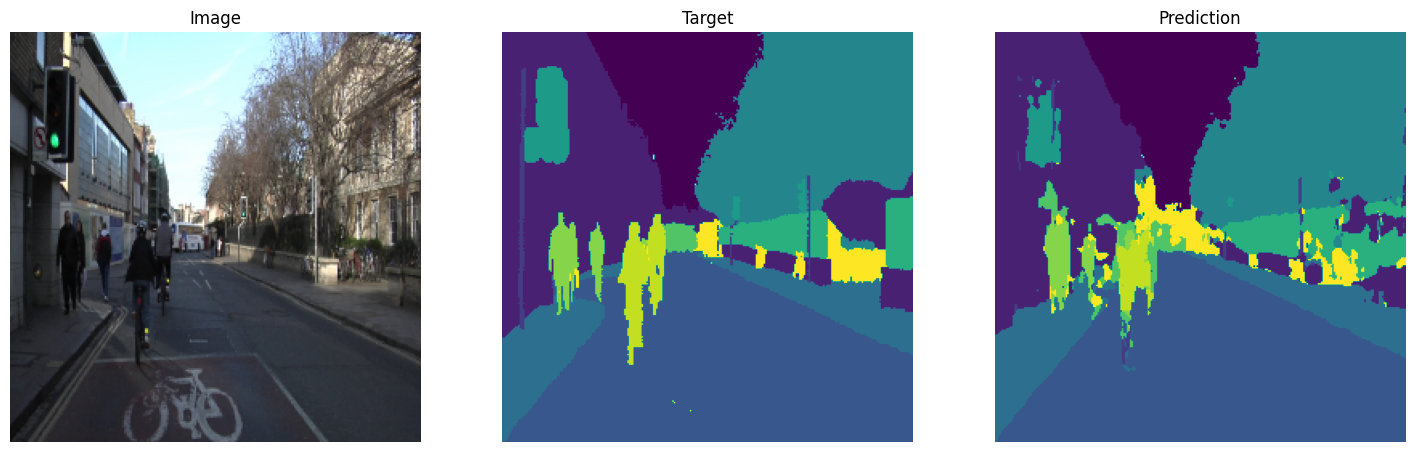

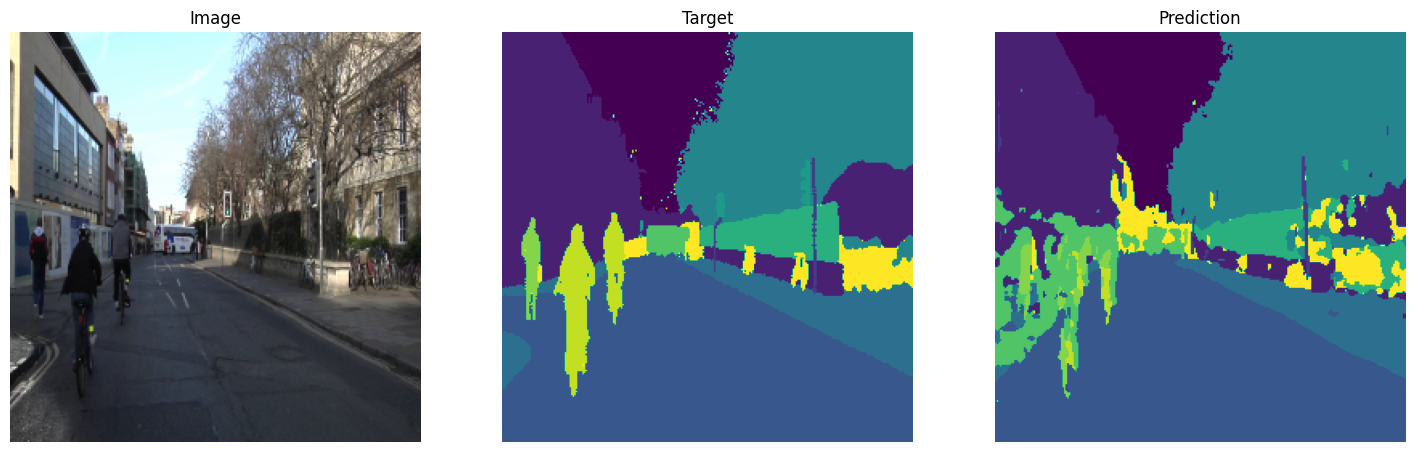

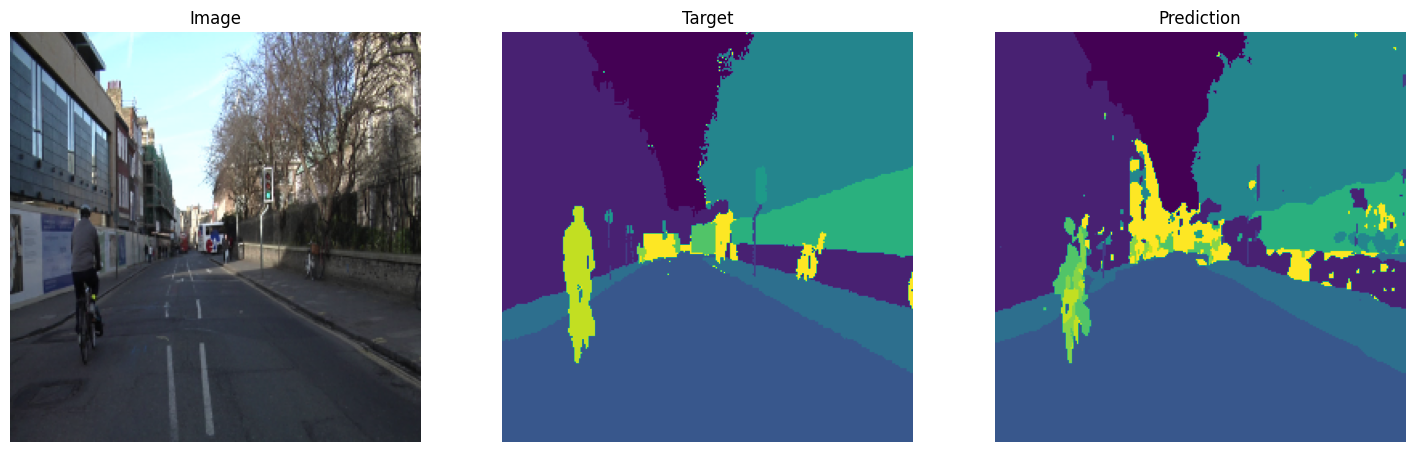

In [23]:
get_img = 3 #inference 3 img

for idx in range(get_img):
  plot_inference(idx, test_dataset)